# Webcam inference with Faster RCNN

This notebook is to show how to do webcam inference with our best model, faster RCNN.

# Initialization



## install and include
First we will install some dependencies first.

In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-18o_bpqm
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-18o_bpqm
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=267013 sha256=c704981f33aca24d62d9ee015305dbc71b287b23335d44cd86ce103e2e68511d
  Stored in directory: /tmp/pip-ephem-wheel-cache-yf3bxcwi/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0
1.5.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free

install detectron2, which is from facebook group

In [2]:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html


In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

import os

## Register the dataset

Register the face and face_mask dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. 

In [0]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode

def get_facemask_dict(img_dir,jsonName):
  json_file = os.path.join("face_mask",img_dir, jsonName)
  with open(json_file) as f:
    imgs_anns = json.load(f)

  dataset_dicts = []
  for idx, v in enumerate(imgs_anns['images']):
    record = {}
    filename = os.path.join("face_mask",img_dir, v['id'])
    height, width = cv2.imread(filename).shape[:2]

    record["file_name"] = filename
    record["image_id"] = idx
    record["height"] = height
    record["width"] = width
    objs = []
    for _, annos in enumerate(imgs_anns['annotations']):
      if annos['image_id'] == v['id']:
        data = annos['bbox']
        obj = {
        "bbox": data,
        "bbox_mode": BoxMode.XYXY_ABS,
        "segmentation": annos['segmentation'],
        "category_id": annos['category_id']-1,
        }
        objs.append(obj)
    record["annotations"] = objs
    dataset_dicts.append(record)
      
  return dataset_dicts

Regitster the datasets to catalog according to if its for training or validation purpose.

In [0]:
from detectron2.data import DatasetCatalog, MetadataCatalog
DatasetCatalog._REGISTERED.clear()
for d in ["train", "val"]:
  DatasetCatalog.register("face_mask_" + d, lambda d=d: get_facemask_dict(d, d+".json"))
  MetadataCatalog.get("face_mask_" + d).set(thing_classes=["face","face_mask"])
face_mask_metadata = MetadataCatalog.get("face_mask_train")

## Import model

We have pretrained one final model's weight with 10000 iterations, let's download it for use.

In [6]:
# Create target directory & all intermediate directories if don't exists
dirName = "model"
os.makedirs(dirName, exist_ok=True) 

# download the model's weight into the folder
!wget "https://cloud.tsinghua.edu.cn/f/a02c6a47fb8448588519/?dl=1" -O model/fastRCNN_weights_final.pth

--2020-06-13 15:03:07--  https://cloud.tsinghua.edu.cn/f/a02c6a47fb8448588519/?dl=1
Resolving cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)... 101.6.8.7
Connecting to cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)|101.6.8.7|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cloud.tsinghua.edu.cn/seafhttp/files/ed7f7f52-789a-4069-abd6-8f97911e3d4f/fastRCNN_final.pth [following]
--2020-06-13 15:03:08--  https://cloud.tsinghua.edu.cn/seafhttp/files/ed7f7f52-789a-4069-abd6-8f97911e3d4f/fastRCNN_final.pth
Reusing existing connection to cloud.tsinghua.edu.cn:443.
HTTP request sent, awaiting response... 200 OK
Length: 330018714 (315M) [application/octet-stream]
Saving to: ‘model/fastRCNN_weights_final.pth’

model/fastRCNN_weig 100%[===================>] 314.73M  16.7MB/s    in 21s     

2020-06-13 15:03:29 (15.1 MB/s) - ‘model/fastRCNN_weights_final.pth’ saved [330018714/330018714]



In [0]:
cfg = get_cfg()

Some initializations:

In [0]:
cfg.DATASETS.TEST = ("face_mask_val",)
cfg.clear()
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

# cfg.MODEL.WEIGHTS = 'drive/My Drive/Colab Notebooks/fastRCNN_final.pth'
cfg.MODEL.WEIGHTS = os.path.join(dirName, "fastRCNN_weights_final.pth")
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # two classes, which is face and face_mask
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

# Start webcam

The webcam works this way, after you clicked "Start Testing", it will went blank and start taking photos for 5 seconds. It will output the inference afterwards

In [0]:
'''
## Camera Capture
Using a webcam to capture images for processing on the runtime.
Source: https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=2viqYx97hPMi
'''

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
        const div = document.createElement('div');
        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        const test = document.createElement('button');
        test.textContent = 'Start Testing';
        div.appendChild(test);

        // show the video in the HTML element
        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize the output to fit the video element.
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        // prints the logs to cell
        let jsLog = function(abc) {
            document.querySelector("#output-area").appendChild(document.createTextNode(`${abc}... `));
        }

        // Wait for Capture to be clicked.
        await new Promise((resolve) => test.onclick = resolve);
        jsLog("Recording... Please smile at camera :)")

        for(i = 1; i <=10; i++) {
            await new Promise(resolve => setTimeout(resolve, 500));

            // await new Promise(((resolve) => test.onclick = resolve )|| new Promise((resolve) => stop.onclick = resolve ));
            if(stop.clicked == true){
                break; 
            }
            // if(test.clicked == true){
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            img = canvas.toDataURL('image/jpeg', quality);
            google.colab.kernel.invokeFunction('notebook.run_algo', [img], {});
            test.clicked = false;

        }

        stream.getVideoTracks()[0].stop(); // stop video stream
    }
  ''')
  display(js) # make the provided HTML, part of the cell
  data = eval_js('takePhoto({})'.format(quality)) # call the takePhoto() JavaScript function

# Enjoy!

<IPython.core.display.Javascript object>

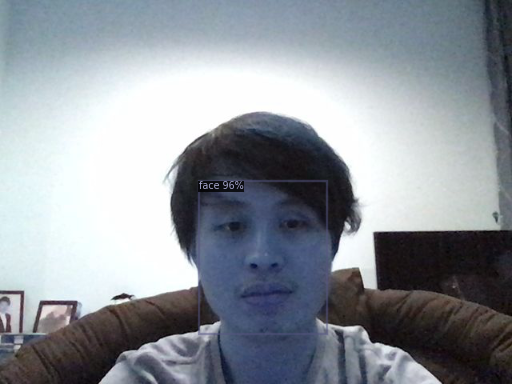

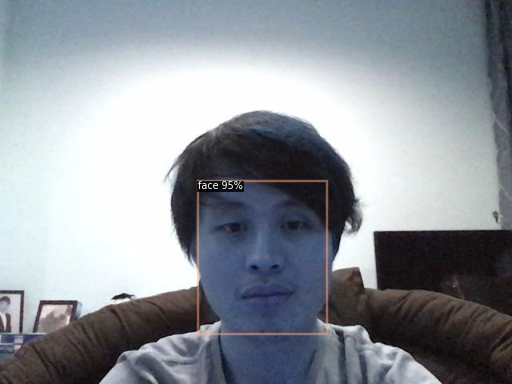

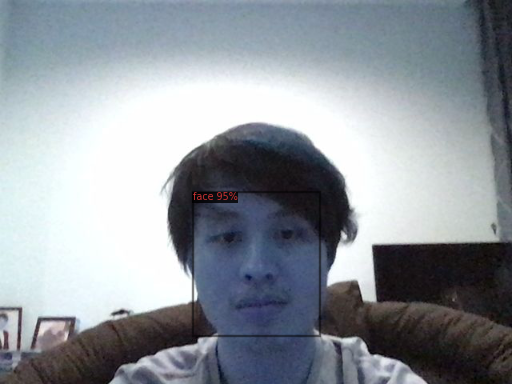

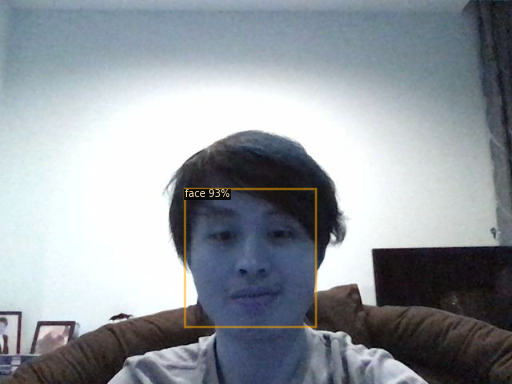

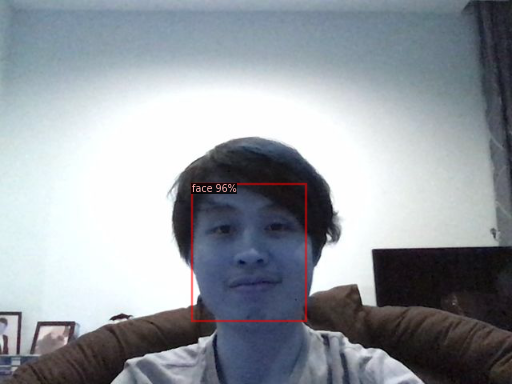

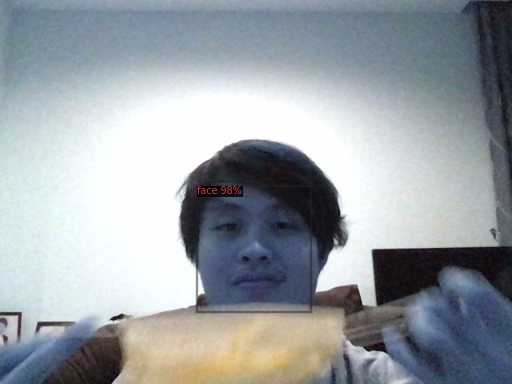

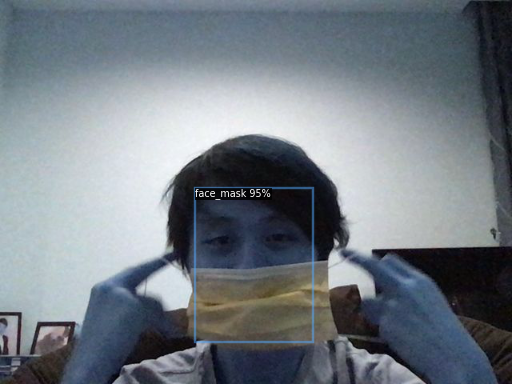

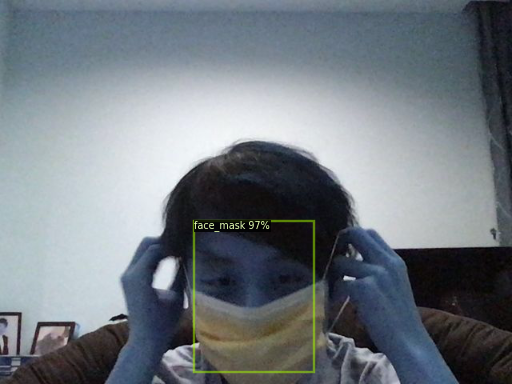

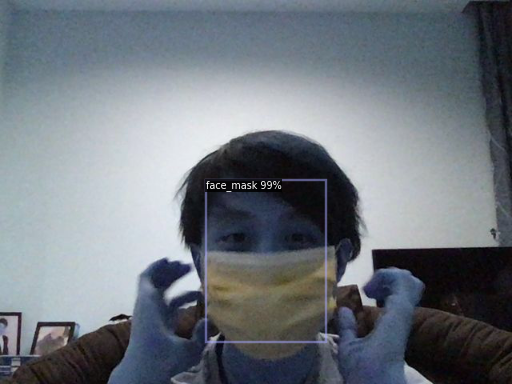

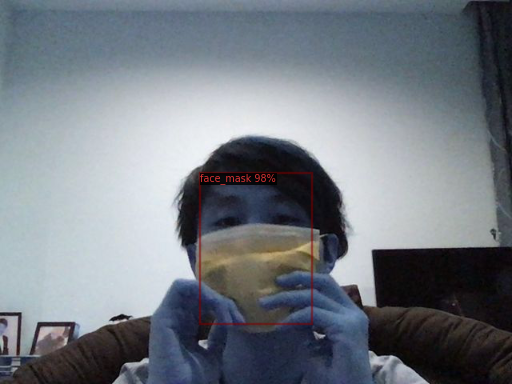

In [13]:
import IPython
from google.colab import output
from google.colab.patches import cv2_imshow

import time
import sys
import numpy as np
import cv2

from PIL import Image
from io import BytesIO
import base64
import logging
from IPython.display import clear_output

def data_uri_to_img(uri):
  """convert base64image to numpy array"""
  try:
    image = base64.b64decode(uri.split(',')[1], validate=True)
    # make the binary image, a PIL image
    image = Image.open(BytesIO(image))
    # convert to numpy array
    image = np.array(image, dtype=np.uint8); 
    return image
  except Exception as e:
    logging.exception(e);print('\n')
    return None

def run_algo(imgB64):
  """
  in Colab, run_algo function gets invoked by the JavaScript, that sends N images every second

  params:
    image: image
  """
  image = data_uri_to_img(imgB64)  
  if image is None:
    print("At run_algo(): image is None.")
    return

  try:
    # Run detection
    # results = model.detect([image], verbose=1)

    outputs = predictor(image)
    # Visualize results
    v = Visualizer(image[:, :, ::-1],
                   metadata=face_mask_metadata, 
                   scale=0.8, 
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    # clear_output(wait=Tru e)
    cv2_imshow(v.get_image()[:, :, ::-1])
    
  except Exception as e:
    logging.exception(e)
    print('\n')

# register this function, so JS code could call this
output.register_callback('notebook.run_algo', run_algo)

# put the JS code in cell and run it
take_photo()